# 语义分割和数据集
与目标检测不同，语义分割可以识别并理解每一个像素的内容；其语义区域的标注和预测都是像素级别的。

## 图像分割和实例分割

- 图像风格属于是将图像划分为若干个组成区域，比如一个狗有眼睛鼻子嘴巴，训练的时候不需要有关图像像素的标签信息。
- 实例分割也叫同时检测并分割，它研究如何识别图像中各个目标实例的像素级区域，与语义分割不同，实例分割不急你要区分语义，还要区分不同的目标实例。图像中有两条狗，那么实例分割还要区分像素属于两条狗中的哪一条。

In [3]:
# PASCAL VOC 2012 语义分割数据集
%matplotlib inline
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append("../")
from pltutils import *

In [4]:
# 第一次运行的话把这个注释去掉
# download_extract("voc2012","VOCdevkit/VOC2012")

In [5]:
def read_voc_images(voc_dir:str,is_train=True):
    """读取所有的VOC图像并进行标注"""
    # 从TXT文件中读取
    txt_fname = os.path.join(voc_dir,"ImageSets","Segmentation","train.txt" if is_train else "val.txt")
    mode = tv.io.image.ImageReadMode.RGB
    
    with open(txt_fname,"r") as f:
        images = f.read().split()
    features ,labels = [],[]
    #循环读取所有的图片和它们的标签
    for i,fname  in enumerate(images):
        features.append(
            tv.io.read_image(os.path.join(
                voc_dir,"JPEGImages",f"{fname}.jpg"
            ), mode)
        )
        labels.append(
            tv.io.read_image(os.path.join(
                voc_dir,"SegmentationClass",f"{fname}.png"
            ),mode)
        )
    return features,labels

In [6]:
train_features,train_labels = read_voc_images('../dataset/VOCdevkit/VOC2012',True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

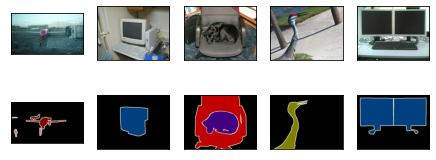

In [7]:
# 显示五幅图片和他们的labels
n = 5
imgs = train_features[0:n]+ train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]

show_images(imgs,2,n)

In [8]:
# 定义颜色所代表的的类别
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [9]:
# 下面两个函数实现颜色和类别的相互映射
def voc_colormap2label():
    """
    构建从RGB到VOC类别索引的映射
    """
    colormap2label = t.zeros(256**3,dtype=t.long)
    for i,colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0]*256+colormap[1])*256 + colormap[2]
        ]=i
    return colormap2label

def voc_label_indeces(colormap:t.Tensor,colormap2label:t.Tensor):
    """
    将VOC标签中的RGB值映射到它们的类别索引
    """
    colormap  = colormap.permute(1,2,0).numpy().astype("int32")
    idx =((colormap[:,:,0]*256 + colormap[:,:,1])*256 + colormap[:,:,2])
    return colormap2label[idx]

In [10]:
y = voc_label_indeces(train_labels[0],voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]


(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

In [11]:
y.shape

torch.Size([281, 500])

数据预处理

In [12]:
def voc_rand_crop(feature,label,height,width):
    """
    随机裁剪特征和标签图像
    """
    rect = tv.transforms.RandomCrop.get_params(feature,(height,width))
    feature = tv.transforms.functional.crop(feature,*rect)
    label = tv.transforms.functional.crop(label,*rect)
    return feature, label

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

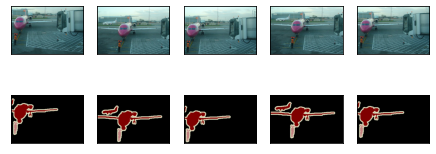

In [13]:
imgs =[]
for _ in range(n):
    imgs  += voc_rand_crop(train_features[0],train_labels[0],200,300)

imgs =[img.permute(1,2,0) for img in imgs]
show_images(imgs[::2]+imgs[1::2],2,n)

# 自定义语义分割数据集类

In [14]:
class VOCSegDataset(t.utils.data.Dataset):
    """
    一个用于加载VOC数据集的自定义数据集
    """
    def __init__(self,is_train,crop_size,voc_dir):
        # 定义transform和裁剪尺寸
        self.transform = tv.transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        self.crop_size =crop_size
        # 读取所有训练集或者测试集的图片
        features,labels = read_voc_images(voc_dir,is_train=is_train)
        # 把图片进行归一化并过滤掉不符合尺寸的图片
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]

        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print(f"read {len(self.features)} examples")
    
    def normalize_image(self,imgs:t.Tensor):
        """
        将图片进行归一化,转成0-1
        """
        return self.transform.forward(imgs.float()/255)
    
    def filter(self,imgs:t.Tensor):
        """
        去掉尺寸不符合的图片
        """
        return [img for img in imgs if(
            img.shape[1]>= self.crop_size[0] and img.shape[2] >= self.crop_size[1]
        )]
    
    def __getitem__(self,idx:int):
        """
        继承自Dataset类
        """
        feature,label = voc_rand_crop(self.features[idx],self.labels[idx],*self.crop_size)
        return (feature,voc_label_indeces(label,self.colormap2label))
    
    def __len__(self):
        return len(self.features)

In [15]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, '../dataset/VOCdevkit/VOC2012')
voc_test = VOCSegDataset(False, crop_size, '../dataset/VOCdevkit/VOC2012')

read 1114 examples
read 1078 examples


In [16]:
voc_train[0][0].shape

torch.Size([3, 320, 480])

In [17]:
voc_train[0][1].shape

torch.Size([320, 480])